In [1]:
import segyio
import numpy as np
from scipy.signal import butter, filtfilt, decimate, resample

x2offsets = lambda x_list: [x[0,:] for x in x_list]

def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    b, a = butter(poles, cutoff, 'highpass', fs=sample_rate)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def lowpass1d(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    b, a = butter(poles, cutoff, 'lowpass', fs=sample_rate)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def get_xyz(raws, offsets, num_sample: int, sampling_rate=250, reduction_velocity=6.0):
    x = [np.array([offset]*(num_sample))/1000 for offset in offsets]
    y = [(np.array([list(range(num_sample))]*len(offset)).T/sampling_rate) for offset in offsets]
    if reduction_velocity is not None:
        for i in range(len(y)): y[i] -= abs(x[i])/reduction_velocity
    z = [raw.T[:num_sample,:] for raw in raws]
    return x,y,z

def read_segy(filename, fix_unsigned_offset=False, reduction_velocity=None, original_delta=250, downsample_t_every=None):
    # new_delta = original_delta if downsample_t_every is None else original_delta/downsample_t_every
    # downsample_t = lambda arr: [lowpass1d(el[:,::downsample_t_every], new_delta/2.1, new_delta) for el in arr] if downsample_t_every is not None else arr
    # downsample_t = lambda arr: [el[:,::downsample_t_every] for el in arr] if downsample_t_every is not None else arr
    if downsample_t_every is None:
        resample_t = lambda arr: arr
        new_delta = original_delta
    elif downsample_t_every < 0:
        resample_t = lambda arr: [resample(el, int(-downsample_t_every*el.shape[-1]), axis=-1) for el in arr]
        new_delta = int(-downsample_t_every*original_delta)
    else:
        resample_t = lambda arr: [decimate(el, downsample_t_every, ftype='fir') for el in arr] 
        new_delta = original_delta/downsample_t_every
    with segyio.open(filename, ignore_geometry=True) as f:
        headers = f.header

        if np.log10(headers[0][1]) > 5:
            raws = [np.array([f.trace.raw[i] for i in range(len(f.trace.raw))])]
            offsets = [np.array([header[37] for header in f.header])]
        else:
            ntrace_ends = []
            for idx, header in enumerate(headers):
                # when shot number defined by TRACE_SEQUENCE_LINE
                if header[21]==0:
                    if header[1]//10000 > len(ntrace_ends):
                        ntrace_ends.append(idx)
                # when station is defined as FieldRecord
                else:
                    if header[9] > len(ntrace_ends):
                        ntrace_ends.append(idx)
            ntrace_ends.append(None)

            raws = [np.array(f.trace.raw[ntrace_ends[i]:ntrace_ends[i+1]]) for i in range(len(ntrace_ends)-1)]
            offsets = [np.array([header[37] for header in f.header[ntrace_ends[i]:ntrace_ends[i+1]]]) for i in range(len(ntrace_ends)-1)]

        if fix_unsigned_offset:
            for idx in range(len(offsets)):
                if offsets[idx][np.argmin(offsets[idx])-1] < offsets[idx][np.argmin(offsets[idx])+1]:
                    offsets[idx][:np.argmin(offsets[idx])] *= -1
                else:
                    offsets[idx][:np.argmin(offsets[idx])+1] *= -1
        raws = resample_t(raws)
        # print(raws[0].shape)
        num_sample = headers[0][115] if (downsample_t_every is None) or downsample_t_every>0 else int(headers[0][115]*-downsample_t_every)
        return get_xyz(raws, offsets, num_sample=num_sample, reduction_velocity=reduction_velocity, sampling_rate=new_delta)

In [4]:

filename = 'OntongJava/obs/kr1005_LineNSobs_s055-1.sgy'

with segyio.open(filename, ignore_geometry=True) as f:
    # print(f)
    # print(min(f.trace[1200]),max(f.trace[1200]))
    # print(f.header[100])
    # raw = np.array(f.trace.raw[:503])
    # raw = np.array(f.trace.raw[503:1005])
    headers = f.header
    # header = headers[1]
    # print(headers[0][115])
    print(headers[200])
    # print(f.trace)
    # print(headers[3][21])
    nshoot = 0
    ntrace_shoot_ends = []
    for idx, header in enumerate(headers):
        if header[1]//10000 > nshoot:
            ntrace_shoot_ends.append(idx)
            nshoot = header[1]//10000
    ntrace_shoot_ends.append(None)
    # print(headers[1005][1])
    raws = [np.array(f.trace.raw[ntrace_shoot_ends[i]:ntrace_shoot_ends[i+1]]) for i in range(len(ntrace_shoot_ends)-1)]
    # print(dict(header).values())
    offsets = [[header[37] for header in f.header[ntrace_shoot_ends[i]:ntrace_shoot_ends[i+1]]] for i in range(len(ntrace_shoot_ends)-1)]
    ns = headers[0][115]
    # print(raw.shape)
#     # print(f.trace[0])
#     data = np.array([f.trace[i][3000:3128] for i in range(320,384)])
# segyio.tools.cube
# data = segyio.tools.cube('/Users/junsu/Downloads/namss.P1-13-LA-GC.mcs.airgun/Data/SEGY/Stack/GC125-stk.sgy', strict=False)
    # print('Survey Inline/Xline shape:' +str(np.shape(seismic_data)[0])+' / ' +str(np.shape(seismic_data)[1]))



{TRACE_SEQUENCE_LINE: 201805, TRACE_SEQUENCE_FILE: 0, FieldRecord: 201805, TraceNumber: 1, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 0, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 0, offset: -208410, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 10, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 1434, GroupWaterDepth: 1707, ElevationScalar: 0, SourceGroupScalar: -1000, SourceX: 566916083, SourceY: -17718912, GroupX: 566083828, GroupY: -10984968, CoordinateUnits: 2, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 20000, TRACE_SAMPLE_INTERVAL: 4000, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType

In [11]:
mcs = True
loc = 60
filename = f'OntongJava/{"mcs"if mcs else"obs"}/kr1005_LineNS{"mcs"if mcs else"obs"}_s{loc:03d}-1.sgy'
x,y,z = read_segy(filename, reduction_velocity=7.0, original_delta=250)

In [7]:
x_obs = x[0]
y_obs = y[0]
z_obs = z[0]

In [96]:
x[0][0]-x_obs[0][1]

array([542.613, 542.563, 542.514, ...,  -2.156,  -2.203,  -2.253])

In [12]:
# x_obs[0]
sampled_x = np.zeros_like(x_obs)
sampled_y = np.zeros_like(y_obs)
sampled_z = np.zeros_like(z_obs)

for i in range(sampled_x.shape[1]):
    sampled_col = np.argmin(abs(x[0][0]-x_obs[0][i]))
    sampled_x[:,i] = x[0][:,sampled_col]
    sampled_y[:,i] = y[0][:,sampled_col]
    sampled_z[:,i] = z[0][:,sampled_col]

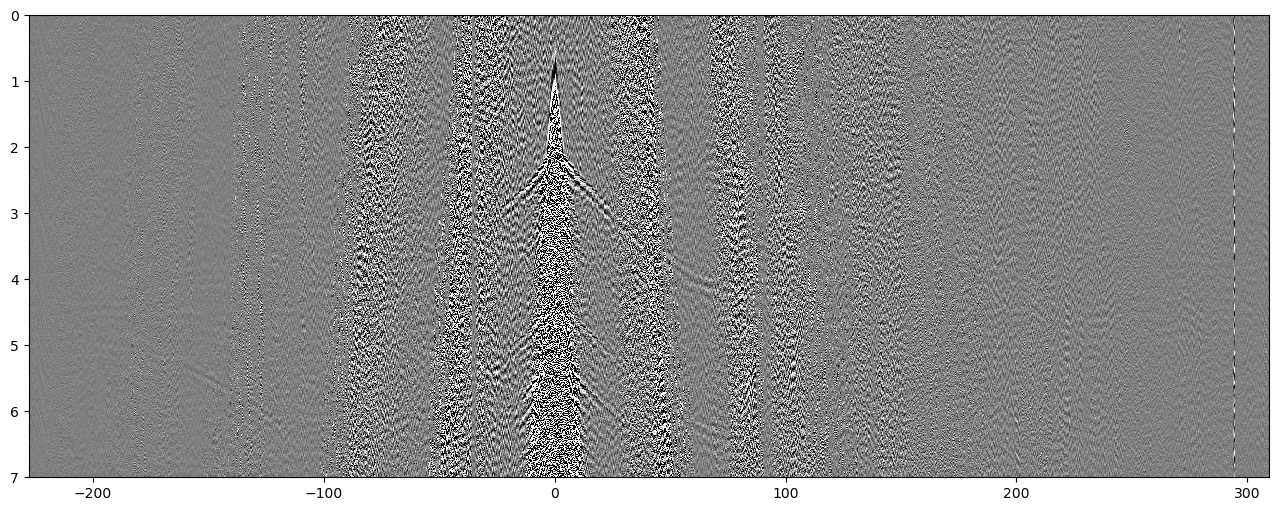

In [14]:
import matplotlib.pyplot as plt
nshoot = 1
clip = 300
# clip = 1
vmin, vmax = -clip, clip

# Figure
figsize=(16, 6)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                       squeeze=False,
                       sharex=True)
axs = axs.ravel()
# val = z[nshoot-1]
val = highpass(sampled_z, 2, 250)
# val = np.load('results/demultiple0116-waveform/canvas-nwp_dwnsmp_inp-0.npy')
# x,y,z = get_xyz(raws, offsets, num_sample=8000, reduction_velocity=None)
# val = np.array([highpass(trace, 2, 250) for trace in z[nshoot-1].T]).T
# im = axs[0].pcolorfast(x[nshoot-1][:val.shape[0],:val.shape[1]], y[nshoot-1][:val.shape[0],:val.shape[1]], val[:-1,:-1], cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
im = axs[0].pcolorfast(sampled_x[:val.shape[0],:val.shape[1]], sampled_y[:val.shape[0],:val.shape[1]], val[:-1,:-1], cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
# im = axs[0].pcolorfast(x_conv[:val.shape[0],:val.shape[1]], y_conv[:val.shape[0],:val.shape[1]], val[:-1,:-1], cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
# x = x[1][:,2:]; y = y[1][:,2:]
# z = z[1][:,2:] - np.flip(z[0][:,3:],axis=1)
# im = axs[0].pcolorfast(x, y, z[:-1,:-1], cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
axs[0].set_aspect('auto')
# axs[0].set_aspect(10)
plt.ylim(0,7)
# plt.xlim(-10,90)
# plt.xlim(-50,50)
axs[0].invert_yaxis()
# fig.colorbar(im, ax=axs[0])

In [27]:
z

[array([[-19, -11, -10, ..., -25, -16, -25],
        [-16, -14, -17, ..., -17, -27, -16],
        [-21,  -9, -17, ..., -19, -16, -26],
        ...,
        [-17, -16, -13, ..., -21, -18, -11],
        [-19, -17, -24, ...,  -9, -25, -13],
        [-15, -12, -16, ...,  -5, -11, -14]], dtype=int32)]

In [3]:
from PIL import Image

def output_image(z_list, x_list, vclip, imgdir, image_size=(256,64), start_reduced_time=0.5, prefilter=None, end_lapse_time=3.06, geospread_corr=0, output_npy=False, reduction_velocity=6.0, sampling_rate=250, initial_count=0):
    offsets = x2offsets(x_list)
    crop = np.zeros(shape=image_size)
    count = 0
    for l in range(len(z_list)):
        timeseries = prefilter(z_list[l]) if prefilter else z_list[l]
        offset_distance = offsets[l]
        time_loop = range(0, int(sampling_rate * end_lapse_time)-crop.shape[0], int(crop.shape[0]*0.2))
        # print(list(time_loop))
        offset_loop = range(0, timeseries.shape[1]-crop.shape[1], int(crop.shape[1]*0.2))
        for i in time_loop:
            for j in offset_loop:
                for k in range(crop.shape[1]):
                    start_sample = i + (int(sampling_rate*(start_reduced_time+abs(offset_distance[j+k])/reduction_velocity)) if reduction_velocity is not None else 0)
                    end_sample = start_sample+crop.shape[0]
                    crop[:,k] = timeseries[start_sample:end_sample,j+k]*max(1,geospread_corr*(abs(offset_distance[j+k])/20))

                if output_npy:
                    crop = np.float32(crop/vclip)
                    np.save(f'{imgdir}/{initial_count+count}', crop.T)
                else:
                    crop[crop<-vclip] = -vclip
                    crop[crop>vclip] = vclip
                    crop+=vclip; crop/=(2*vclip);
                    crop_int=np.uint8(255*crop)
                    # crop = np.int8
                    # Image.fromarray(crop_int).save(f'{imgdir}/st{t}rt{i}of{j}.png')
                    Image.fromarray(crop_int.T).save(f'{imgdir}/{initial_count+count}.png')
                count+=1
    print(f"Image saved: {count} units with {len(offset_loop)} on offset axis and {len(time_loop)} on time axis")
    return count

In [31]:
z[0].shape

(20000, 10975)

In [8]:
# loc_nums = 10*np.arange(10)+5
loc_nums = np.arange(100)+1
prestacked = []
stacked = []
x_obs_list = []
x_mcs_list = []
count = 0

for loc in loc_nums:
    obsdata = f'OntongJava/obs/kr1005_LineNSobs_s{loc:03d}-1.sgy'
    mcsdata = f'OntongJava/mcs/kr1005_LineNSmcs_s{loc:03d}-1.sgy'

    x,y,z = read_segy(obsdata, reduction_velocity=6.0, original_delta=250)
    x1_padded = np.zeros((25000, x[0].shape[1]))
    x1_padded[:20000,:] = x[0][:20000,:]
    y1_padded = np.zeros((25000, y[0].shape[1]))
    y1_padded[:20000,:] = y[0][:20000,:]
    z1_padded = np.zeros((25000, z[0].shape[1]))
    z1_padded[:20000,:] = z[0][:20000,:]

    x,y,z = read_segy(mcsdata, reduction_velocity=6.0, original_delta=250)
    x2_padded = np.zeros((25000, x[0].shape[1]))
    x2_padded[:20000,:] = x[0][:20000,:]
    z2_padded = np.zeros((25000, z[0].shape[1]))
    z2_padded[:20000,:] = z[0][:20000,:]

    sampled_x = np.zeros_like(x1_padded)
    sampled_y = np.zeros_like(z1_padded)
    sampled_z = np.zeros_like(z1_padded)

    for i in range(sampled_x.shape[1]):
        sampled_col = np.argmin(abs(x2_padded[0]-x1_padded[0][i]))
        sampled_x[:,i] = x2_padded[:,sampled_col]
        sampled_y[:,i] = x2_padded[:,sampled_col]
        sampled_z[:,i] = z2_padded[:,sampled_col]

    # stacked += ([z1_padded])
    # prestacked += ([sampled_z])
    # x_obs_list += ([x1_padded])
    # x_mcs_list += ([sampled_x])

    output_image([sampled_z], [sampled_x], 300, imgdir='OntongJava/dataset/prestacked', prefilter=lambda z: highpass(z, 2, 250), start_reduced_time=0, end_lapse_time=7.3, geospread_corr=0.2, output_npy=True, reduction_velocity=6.0, sampling_rate=250, initial_count=count)
    count_added = output_image([z1_padded], [x1_padded], 300, imgdir='OntongJava/dataset/stacked_paired', prefilter=lambda z: highpass(z, 2, 250), start_reduced_time=0, end_lapse_time=7.3, geospread_corr=0, output_npy=True, reduction_velocity=6.0, sampling_rate=250, initial_count=count)
    count = count + count_added
    print('new count', count)


Image saved: 6727 units with 217 on offset axis and 31 on time axis
Image saved: 6727 units with 217 on offset axis and 31 on time axis
new count 6727
Image saved: 6727 units with 217 on offset axis and 31 on time axis
Image saved: 6727 units with 217 on offset axis and 31 on time axis
new count 13454
Image saved: 6727 units with 217 on offset axis and 31 on time axis
Image saved: 6727 units with 217 on offset axis and 31 on time axis
new count 20181
Image saved: 6727 units with 217 on offset axis and 31 on time axis
Image saved: 6727 units with 217 on offset axis and 31 on time axis
new count 26908
Image saved: 6727 units with 217 on offset axis and 31 on time axis
Image saved: 6727 units with 217 on offset axis and 31 on time axis
new count 33635
Image saved: 6727 units with 217 on offset axis and 31 on time axis
Image saved: 6727 units with 217 on offset axis and 31 on time axis
new count 40362
Image saved: 6727 units with 217 on offset axis and 31 on time axis
Image saved: 6727 uni